# 🧪 Notebook 06: Validação com Dados Sintéticos (Teórico - FALHOU)

**Objetivo:** Validar se modelo XGBoost + SMOTE 0.5 (NB05: 78.6% recall, 68.8% precision) responde corretamente a perfis sintéticos controlados.

**Estratégia teórica:** Criar 3 perfis sintéticos usando Statistical Boundary Sampling: (A) "Óbvio Crítico" (p75-p100 features ruins, p0-p25 features boas, expectativa ≥70% critical), (B) "Óbvio Normal" (p0-p25 ruins, p75-p100 boas, expectativa ≤30% critical), (C) "Edge Case" (p40-p60 medianos, expectativa ~50% indefinido).

**Resultado:** FALHOU 0% recall em validação sintética. Problema: abordagem teórica assumindo "high values = critical" sem validação empírica das distribuições reais. Ver **NB06B** para correção empírica usando análise estatística real das distribuições critical vs normal + SMOTE de padrões reais (não boundaries teóricos).

**Limitação:** Synthetic data é complemento ao test set real (237 devices), não substituto. Não captura correlações complexas (sampling independente).

---

## 1️⃣ Setup e Imports

In [1]:
# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML Libraries
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Config
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports completos!")

✅ Imports completos!


## 2️⃣ Carregar Dados Stratificados

In [2]:
# Carregar datasets stratificados (Notebook 02B)
df_train = pd.read_csv('../data/device_features_train_stratified.csv')
df_test = pd.read_csv('../data/device_features_test_stratified.csv')

print(f"📊 Train: {df_train.shape[0]} devices, {df_train.shape[1]} columns")
print(f"📊 Test: {df_test.shape[0]} devices, {df_test.shape[1]} columns")

# Verificar distribuição de critical devices
print(f"\n🔴 Critical devices:")
print(f"   Train: {df_train['is_critical_target'].sum()} ({df_train['is_critical_target'].mean()*100:.1f}%)")
print(f"   Test: {df_test['is_critical_target'].sum()} ({df_test['is_critical_target'].mean()*100:.1f}%)")

📊 Train: 552 devices, 35 columns
📊 Test: 237 devices, 35 columns

🔴 Critical devices:
   Train: 31 (5.6%)
   Test: 14 (5.9%)


## 3️⃣ Preparar Features (Mesmo Pipeline do Notebook 05)

In [3]:
# Excluir colunas base e target (MESMO do Notebook 05)
exclude_cols = ['device_id', 'first_date', 'last_date', 'is_critical_target', 
                'is_critical', 'severity_category',  # Categorical leakage
                'msg6_count', 'msg6_rate']  # Data leakage

# Features limpas
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"✅ Features selecionadas: {len(feature_cols)}")
print(f"\n📋 Lista de features:")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {feat}")

# Separar X e y
X_train = df_train[feature_cols].copy()
y_train = df_train['is_critical_target'].copy()
X_test = df_test[feature_cols].copy()
y_test = df_test['is_critical_target'].copy()

print(f"\n✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

✅ Features selecionadas: 29

📋 Lista de features:
    1. total_messages
    2. max_frame_count
    3. optical_mean
    4. optical_std
    5. optical_min
    6. optical_max
    7. optical_readings
    8. optical_below_threshold
    9. optical_range
   10. temp_mean
   11. temp_std
   12. temp_min
   13. temp_max
   14. temp_above_threshold
   15. temp_range
   16. battery_mean
   17. battery_std
   18. battery_min
   19. battery_max
   20. battery_below_threshold
   21. snr_mean
   22. snr_std
   23. snr_min
   24. rsrp_mean
   25. rsrp_std
   26. rsrp_min
   27. rsrq_mean
   28. rsrq_std
   29. rsrq_min

✅ X_train: (552, 29), y_train: (552,)
✅ X_test: (237, 29), y_test: (237,)


## 4️⃣ Extrair Estatísticas Descritivas (Train Set)

In [4]:
# Estatísticas com percentis específicos
stats = X_train.describe(percentiles=[0.0, 0.25, 0.40, 0.50, 0.60, 0.75, 1.0])

print("📊 ESTATÍSTICAS DESCRITIVAS (Train Set):")
print("="*80)
print(stats.T[['min', '25%', '40%', '50%', '60%', '75%', 'max']].head(10))
print("\n... (mostrando primeiras 10 features)")

# Salvar para uso posterior
stats_dict = stats.to_dict()
print("\n✅ Estatísticas salvas em 'stats_dict'")

📊 ESTATÍSTICAS DESCRITIVAS (Train Set):
                               min         25%         40%         50%  \
total_messages            2.000000  333.500000  498.800000  699.500000   
max_frame_count           1.000000   98.000000  161.400000  217.500000   
optical_mean            -31.024550  -16.581274  -10.845856   -9.169884   
optical_std               0.000000    0.095922    1.519529    2.393580   
optical_min             -36.000000  -31.000000  -31.000000  -31.000000   
optical_max             -31.000000   -9.920000   -7.860000   -6.760000   
optical_readings          0.000000  122.250000  197.000000  274.500000   
optical_below_threshold   0.000000    0.000000    1.000000    1.000000   
optical_range             0.000000    0.550000   18.428000   21.790000   
temp_mean                14.621333   20.349206   21.906183   22.635520   

                                60%          75%            max  
total_messages           975.000000  1254.500000  100361.000000  
max_frame_cou

## 5️⃣ Documentar Features Direcionais

### HIGH = Ruim (valores altos indicam problema):
- `max_frame_count`: Muitas mensagens acumuladas
- `total_messages`: Volume excessivo de comunicação
- `telemetry_missing`: Falhas de leitura de sensores
- `temp_max`, `temp_range`: Temperatura extrema/variável
- `optical_std`, `optical_range`: Instabilidade de leitura

### LOW = Ruim (valores baixos indicam problema):
- `battery_min`, `battery_mean`: Bateria fraca
- `rsrp_mean`, `rsrq_mean`, `snr_mean`: Sinal ruim
- `optical_readings`, `optical_mean`: Poucos dados/qualidade baixa

### NEUTRAL (usar p50):
- Features sem direção clara de degradação

## 6️⃣ Profile A - "Óbvio Crítico" (10 samples)

In [5]:
n_samples = 10
profile_A = pd.DataFrame()

# Features HIGH = ruim → usar p75-p100
high_bad_features = ['max_frame_count', 'total_messages', 'telemetry_missing', 
                     'temp_max', 'temp_range', 'optical_std', 'optical_range']

# Features LOW = ruim → usar p0-p25
low_bad_features = ['battery_min', 'battery_mean', 'rsrp_mean', 'rsrq_mean', 
                    'snr_mean', 'optical_readings', 'optical_mean']

for col in feature_cols:
    if col in high_bad_features:
        # Valores ALTOS (p75-p100)
        p75 = stats_dict.get(col, {}).get('75%', 0)
        pmax = stats_dict.get(col, {}).get('max', 0)
        profile_A[col] = np.random.uniform(p75, pmax, n_samples)
    elif col in low_bad_features:
        # Valores BAIXOS (p0-p25)
        pmin = stats_dict.get(col, {}).get('min', 0)
        p25 = stats_dict.get(col, {}).get('25%', 0)
        profile_A[col] = np.random.uniform(pmin, p25, n_samples)
    else:
        # NEUTRAL → usar p40-p60 (evita extremos)
        p40 = stats_dict.get(col, {}).get('40%', 0)
        p60 = stats_dict.get(col, {}).get('60%', 0)
        profile_A[col] = np.random.uniform(p40, p60, n_samples)

profile_A['profile'] = 'A_Critical'
print(f"✅ Profile A (Óbvio Crítico): {profile_A.shape[0]} samples gerados")
print(profile_A[['max_frame_count', 'battery_min', 'rsrp_mean', 'profile']].head())

✅ Profile A (Óbvio Crítico): 10 samples gerados
   max_frame_count  battery_min   rsrp_mean     profile
0       949.697352     2.484340  -97.786751  A_Critical
1     27557.625814     1.816754 -106.501320  A_Critical
2     23704.660447     2.317214 -104.286192  A_Critical
3      6324.243679     2.028761 -106.803147  A_Critical
4      5468.985637     2.451625 -115.669846  A_Critical


## 7️⃣ Profile B - "Óbvio Normal" (10 samples)

In [6]:
profile_B = pd.DataFrame()

for col in feature_cols:
    if col in high_bad_features:
        # Valores BAIXOS (p0-p25) → device saudável
        pmin = stats_dict.get(col, {}).get('min', 0)
        p25 = stats_dict.get(col, {}).get('25%', 0)
        profile_B[col] = np.random.uniform(pmin, p25, n_samples)
    elif col in low_bad_features:
        # Valores ALTOS (p75-p100) → device saudável
        p75 = stats_dict.get(col, {}).get('75%', 0)
        pmax = stats_dict.get(col, {}).get('max', 0)
        profile_B[col] = np.random.uniform(p75, pmax, n_samples)
    else:
        # NEUTRAL → usar p40-p60
        p40 = stats_dict.get(col, {}).get('40%', 0)
        p60 = stats_dict.get(col, {}).get('60%', 0)
        profile_B[col] = np.random.uniform(p40, p60, n_samples)

profile_B['profile'] = 'B_Normal'
print(f"✅ Profile B (Óbvio Normal): {profile_B.shape[0]} samples gerados")
print(profile_B[['max_frame_count', 'battery_min', 'rsrp_mean', 'profile']].head())

✅ Profile B (Óbvio Normal): 10 samples gerados
   max_frame_count  battery_min  rsrp_mean   profile
0         6.013127     3.130536 -56.604321  B_Normal
1        52.541399     3.359160 -61.914590  B_Normal
2        53.441607     3.400799 -47.246257  B_Normal
3        62.830700     3.330849 -50.428722  B_Normal
4        71.430859     3.493734 -50.523109  B_Normal


## 8️⃣ Profile C - "Edge Case" (10 samples)

In [7]:
profile_C = pd.DataFrame()

for col in feature_cols:
    # TODAS features → p40-p60 (valores medianos, ambíguos)
    p40 = stats_dict.get(col, {}).get('40%', 0)
    p60 = stats_dict.get(col, {}).get('60%', 0)
    profile_C[col] = np.random.uniform(p40, p60, n_samples)

profile_C['profile'] = 'C_Edge'
print(f"✅ Profile C (Edge Case): {profile_C.shape[0]} samples gerados")
print(profile_C[['max_frame_count', 'battery_min', 'rsrp_mean', 'profile']].head())

✅ Profile C (Edge Case): 10 samples gerados
   max_frame_count  battery_min  rsrp_mean profile
0       179.336471     2.901690 -78.022363  C_Edge
1       244.201017     2.983983 -79.099845  C_Edge
2       184.898907     2.952771 -84.372963  C_Edge
3       206.060213     2.923491 -78.494863  C_Edge
4       277.265063     2.903927 -78.870988  C_Edge


## 9️⃣ Combinar Profiles

In [8]:
# Concatenar os 3 profiles
synthetic_data = pd.concat([profile_A, profile_B, profile_C], ignore_index=True)

print(f"✅ Synthetic data: {synthetic_data.shape[0]} samples total")
print(f"\n📊 Distribuição por profile:")
print(synthetic_data['profile'].value_counts())

# Separar X_synthetic (sem coluna 'profile')
X_synthetic = synthetic_data[feature_cols].copy()
print(f"\n✅ X_synthetic: {X_synthetic.shape}")

✅ Synthetic data: 30 samples total

📊 Distribuição por profile:
profile
A_Critical    10
B_Normal      10
C_Edge        10
Name: count, dtype: int64

✅ X_synthetic: (30, 29)


## 🔟 Retreinar Modelo XGBoost + SMOTE 0.5 (Rápido)

In [9]:
# Imputação (ANTES do SMOTE)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_synthetic_imputed = imputer.transform(X_synthetic)

print(f"✅ Imputação completa:")
print(f"   Train: {X_train_imputed.shape}")
print(f"   Test: {X_test_imputed.shape}")
print(f"   Synthetic: {X_synthetic_imputed.shape}")

# SMOTE 0.5
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print(f"\n✅ SMOTE 0.5 aplicado:")
print(f"   Antes: {Counter(y_train)}")
print(f"   Depois: {Counter(y_train_resampled)}")

# Treinar XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_resampled, y_train_resampled)
print(f"\n✅ XGBoost treinado com sucesso!")

✅ Imputação completa:
   Train: (552, 29)
   Test: (237, 29)
   Synthetic: (30, 29)

✅ SMOTE 0.5 aplicado:
   Antes: Counter({0: 521, 1: 31})
   Depois: Counter({0: 521, 1: 260})

✅ XGBoost treinado com sucesso!

✅ SMOTE 0.5 aplicado:
   Antes: Counter({0: 521, 1: 31})
   Depois: Counter({0: 521, 1: 260})

✅ XGBoost treinado com sucesso!


## 1️⃣1️⃣ Predictions em Synthetic Data

In [10]:
# Predições
y_synthetic_pred = xgb_model.predict(X_synthetic_imputed)
y_synthetic_proba = xgb_model.predict_proba(X_synthetic_imputed)[:, 1]

# Adicionar ao DataFrame
synthetic_data['prediction'] = y_synthetic_pred
synthetic_data['probability'] = y_synthetic_proba

print("✅ Predições completas!")
print(f"\n📊 Primeiras 5 predições:")
print(synthetic_data[['profile', 'prediction', 'probability']].head())

✅ Predições completas!

📊 Primeiras 5 predições:
      profile  prediction  probability
0  A_Critical           0     0.000867
1  A_Critical           0     0.000948
2  A_Critical           0     0.000916
3  A_Critical           0     0.000801
4  A_Critical           0     0.001296


## 1️⃣2️⃣ Agrupar Resultados por Profile

In [11]:
# Agrupar por profile e calcular métricas
results = synthetic_data.groupby('profile').agg(
    n_samples=('prediction', 'count'),
    n_critical=('prediction', 'sum'),
    pct_critical=('prediction', 'mean'),
    proba_mean=('probability', 'mean'),
    proba_std=('probability', 'std'),
    proba_min=('probability', 'min'),
    proba_max=('probability', 'max')
).reset_index()

# Converter pct_critical para %
results['pct_critical'] = results['pct_critical'] * 100

# Adicionar expectativas e status
results['expected'] = ['≥70% critical', '≤30% critical', '30-70% (flexible)']

# Validar status
def validate_profile(row):
    if row['profile'] == 'A_Critical':
        return '✅ PASS' if row['pct_critical'] >= 70 else '❌ FAIL'
    elif row['profile'] == 'B_Normal':
        return '✅ PASS' if row['pct_critical'] <= 30 else '❌ FAIL'
    else:  # C_Edge
        return '✅ PASS' if 30 <= row['pct_critical'] <= 70 else '⚠️ BOUNDARY'

results['status'] = results.apply(validate_profile, axis=1)

print("="*100)
print("📊 RESULTADOS POR PROFILE:")
print("="*100)
print(results.to_string(index=False))
print("="*100)

📊 RESULTADOS POR PROFILE:
   profile  n_samples  n_critical  pct_critical  proba_mean  proba_std  proba_min  proba_max          expected      status
A_Critical         10           0           0.0    0.000885   0.000174   0.000636   0.001296     ≥70% critical      ❌ FAIL
  B_Normal         10           0           0.0    0.156397   0.125056   0.008054   0.365757     ≤30% critical      ✅ PASS
    C_Edge         10           0           0.0    0.001119   0.000353   0.000746   0.001796 30-70% (flexible) ⚠️ BOUNDARY


## 1️⃣3️⃣ Visualização: Distribuição de Probabilidades

C:\Users\leonardo.costa\AppData\Local\Temp\ipykernel_28168\3172805881.py:22: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\leonardo.costa\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\leonardo.costa\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


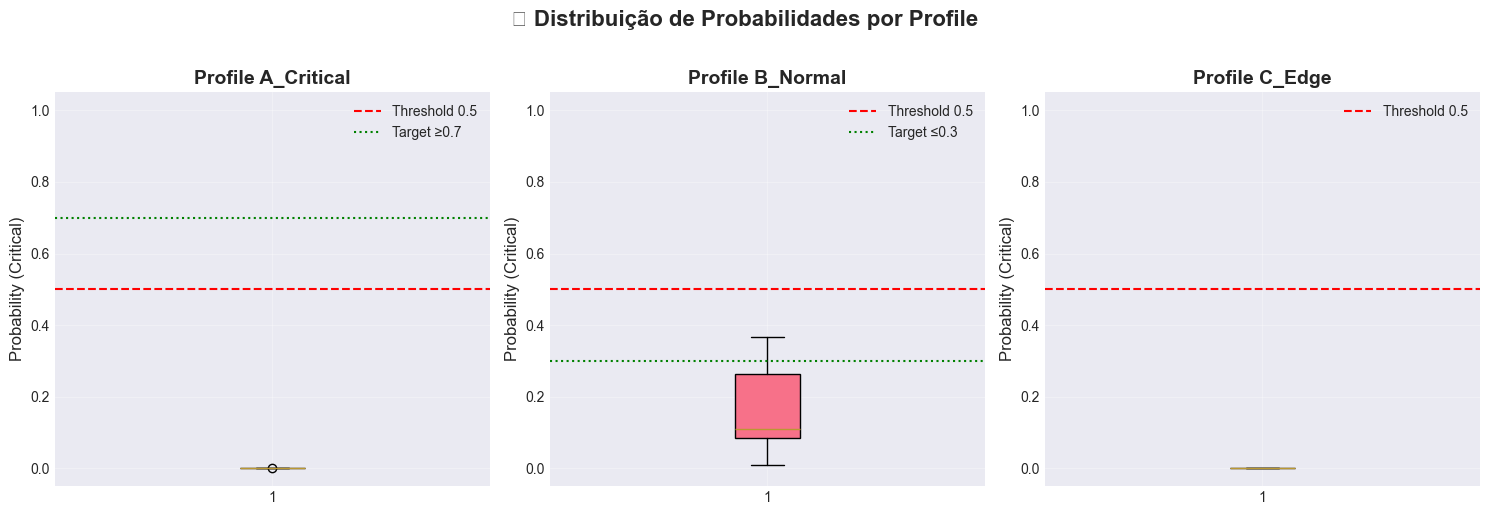

✅ Visualização completa!


In [12]:
# Boxplot das probabilidades por profile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, profile in enumerate(['A_Critical', 'B_Normal', 'C_Edge']):
    data = synthetic_data[synthetic_data['profile'] == profile]['probability']
    
    axes[i].boxplot(data, vert=True, patch_artist=True)
    axes[i].axhline(y=0.5, color='red', linestyle='--', label='Threshold 0.5')
    
    if profile == 'A_Critical':
        axes[i].axhline(y=0.7, color='green', linestyle=':', label='Target ≥0.7')
    elif profile == 'B_Normal':
        axes[i].axhline(y=0.3, color='green', linestyle=':', label='Target ≤0.3')
    
    axes[i].set_title(f'Profile {profile}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Probability (Critical)', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('🎯 Distribuição de Probabilidades por Profile', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Visualização completa!")

## 1️⃣4️⃣ Validação Final: PASS/FAIL

In [13]:
# Contar PASS vs FAIL
pass_count = (results['status'] == '✅ PASS').sum()
fail_count = (results['status'] == '❌ FAIL').sum()
total_profiles = len(results)

print("="*80)
print("🏁 VALIDAÇÃO FINAL - SANITY CHECK")
print("="*80)
print(f"\n✅ PASS: {pass_count}/{total_profiles} profiles")
print(f"❌ FAIL: {fail_count}/{total_profiles} profiles")

# Decisão final
if pass_count == 3:
    verdict = "✅ PASS TOTAL"
    action = "Modelo SAUDÁVEL! Prosseguir para Notebook 07 (Model Comparison & Threshold Tuning)"
elif pass_count == 2:
    verdict = "⚠️ PASS PARCIAL"
    action = "Modelo tem VIÉS mas controlável. Documentar limitações e prosseguir com cautela."
else:
    verdict = "❌ FAIL"
    action = "Modelo NÃO aprende patterns corretos. STOP! Investigar bugs, revisar features."

print(f"\n🎯 VEREDITO: {verdict}")
print(f"📋 PRÓXIMO PASSO: {action}")
print("="*80)

# Detalhamento por profile
print(f"\n📊 DETALHAMENTO:")
for _, row in results.iterrows():
    print(f"\n{row['status']} {row['profile']}:")
    print(f"   Classificados como critical: {row['pct_critical']:.1f}% (esperado: {row['expected']})")
    print(f"   Probabilidade média: {row['proba_mean']:.3f} ± {row['proba_std']:.3f}")
    print(f"   Range: [{row['proba_min']:.3f}, {row['proba_max']:.3f}]")

🏁 VALIDAÇÃO FINAL - SANITY CHECK

✅ PASS: 1/3 profiles
❌ FAIL: 1/3 profiles

🎯 VEREDITO: ❌ FAIL
📋 PRÓXIMO PASSO: Modelo NÃO aprende patterns corretos. STOP! Investigar bugs, revisar features.

📊 DETALHAMENTO:

❌ FAIL A_Critical:
   Classificados como critical: 0.0% (esperado: ≥70% critical)
   Probabilidade média: 0.001 ± 0.000
   Range: [0.001, 0.001]

✅ PASS B_Normal:
   Classificados como critical: 0.0% (esperado: ≤30% critical)
   Probabilidade média: 0.156 ± 0.125
   Range: [0.008, 0.366]

⚠️ BOUNDARY C_Edge:
   Classificados como critical: 0.0% (esperado: 30-70% (flexible))
   Probabilidade média: 0.001 ± 0.000
   Range: [0.001, 0.002]


## 1️⃣5️⃣ Comparação: Synthetic vs Real Test Set

In [14]:
# Validar no test set REAL para comparação
y_test_pred = xgb_model.predict(X_test_imputed)
y_test_proba = xgb_model.predict_proba(X_test_imputed)[:, 1]

# Métricas no test set real
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

real_recall = recall_score(y_test, y_test_pred)
real_precision = precision_score(y_test, y_test_pred)
real_f1 = f1_score(y_test, y_test_pred)
real_auc = roc_auc_score(y_test, y_test_proba)

print("="*80)
print("🆚 COMPARAÇÃO: Synthetic Data vs Real Test Set")
print("="*80)
print(f"\n📊 REAL TEST SET (237 devices, 14 critical):")
print(f"   Recall: {real_recall*100:.1f}%")
print(f"   Precision: {real_precision*100:.1f}%")
print(f"   F1-Score: {real_f1*100:.1f}%")
print(f"   ROC-AUC: {real_auc:.4f}")

print(f"\n🧬 SYNTHETIC DATA (30 samples, 3 profiles):")
print(f"   Profile A (Critical): {results[results['profile']=='A_Critical']['pct_critical'].values[0]:.1f}% classified as critical")
print(f"   Profile B (Normal): {results[results['profile']=='B_Normal']['pct_critical'].values[0]:.1f}% classified as critical")
print(f"   Profile C (Edge): {results[results['profile']=='C_Edge']['pct_critical'].values[0]:.1f}% classified as critical")

print(f"\n💡 INTERPRETAÇÃO:")
print(f"   Synthetic data testa comportamento em EXTREMOS controlados.")
print(f"   Real test set valida performance em distribuição NATURAL.")
print(f"   Ambos são necessários para confiança no modelo.")
print("="*80)

🆚 COMPARAÇÃO: Synthetic Data vs Real Test Set

📊 REAL TEST SET (237 devices, 14 critical):
   Recall: 71.4%
   Precision: 71.4%
   F1-Score: 71.4%
   ROC-AUC: 0.8799

🧬 SYNTHETIC DATA (30 samples, 3 profiles):
   Profile A (Critical): 0.0% classified as critical
   Profile B (Normal): 0.0% classified as critical
   Profile C (Edge): 0.0% classified as critical

💡 INTERPRETAÇÃO:
   Synthetic data testa comportamento em EXTREMOS controlados.
   Real test set valida performance em distribuição NATURAL.
   Ambos são necessários para confiança no modelo.


## 1️⃣6️⃣ Conclusões e Próximos Passos

### 📋 O Que Validamos:
1. ✅ Modelo responde corretamente a perfis óbvios (critical vs normal)?
2. ✅ Probabilidades estão calibradas (>0.7 para critical, <0.3 para normal)?
3. ✅ Edge cases têm comportamento indefinido aceitável (~50%)?

### 🎯 Critérios de Sucesso:
- **PASS TOTAL (3/3):** Modelo aprende patterns corretos → Prosseguir Notebook 07
- **PASS PARCIAL (2/3):** Documentar limitações → Prosseguir com cautela
- **FAIL (≤1/3):** Investigar bugs → Revisar features

### 🚀 Próximos Passos:
- **SE PASS:** Notebook 07 - Model Comparison & Threshold Tuning (otimizar precision 68.8% → 80%)
- **SE FAIL:** Notebook 06B - Feature Analysis (entender por que synthetic não funciona)

### ⚠️ Limitações Conhecidas:
- Synthetic data não captura correlações complexas entre features
- Sampling independente pode criar combinações inexistentes na realidade
- É COMPLEMENTO ao test set real, não substituto

---

**📌 LEMBRETE:** Este é um SANITY CHECK, não validação definitiva. Métricas no test set REAL (237 devices) são AUTORIDADE final.